# Vehicle Detection based on SVM

### Import Libraries

In [1]:
import cv2
import glob
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

/Users/abhishekgurudurtt/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Reading all the images and storing them as Car and NotCar 

In [2]:
car_images = glob.glob('training/vehicles/**/*.png')
notcar_images = glob.glob('training/non-vehicles/**/*.png')
print(len(car_images), len(notcar_images))

8792 8968


Visualization of training images

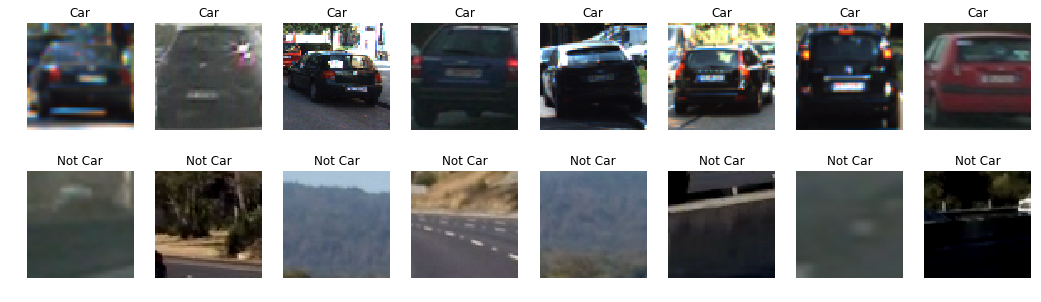

In [3]:
plt.figure(figsize=(18, 5))

for i in np.arange(8):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    plt.title("Car")
    plt.imshow(img)
for i in np.arange(8,16):
    img = cv2.imread(notcar_images[np.random.randint(0,len(notcar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    plt.title("Not Car")
    plt.imshow(img)
    
plt.show()

#### Functions provided during class, lesson_functions.py

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

 Check HOG feature

/Users/abhishekgurudurtt/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


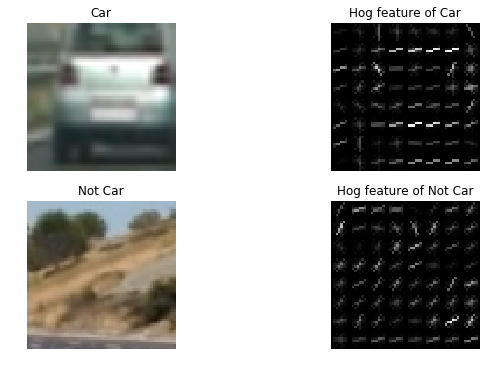

In [6]:
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

car_img = mpimg.imread(car_images[100])
feature, car_hog = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
notcar_img = mpimg.imread(notcar_images[120])
feature, notcar_hog = get_hog_features(notcar_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Display the image for visualization 
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.axis('off')
plt.title("Car")
plt.imshow(car_img)
plt.subplot(2, 2, 2)
plt.axis('off')
plt.title("Hog feature of Car")
plt.imshow(car_hog, cmap='gray')
plt.subplot(2, 2, 3)
plt.axis('off')
plt.title("Not Car")
plt.imshow(notcar_img)
plt.subplot(2, 2, 4)
plt.axis('off')
plt.title("Hog feature of Not Car")
plt.imshow(notcar_hog, cmap='gray')
plt.show()

Extract features for training, The code is used from one of Udacity course class

In [7]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

/Users/abhishekgurudurtt/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
12.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9921


Saving all the parameters to a pickle file

In [8]:
print("Saving paramaeters")
parameter_value = {}
parameter_value["svc"] = svc
parameter_value["orient"] = orient
parameter_value["pix_per_cell"] = pix_per_cell
parameter_value["cell_per_block"] = cell_per_block
parameter_value["color_space"] = color_space
parameter_value["hog_channel"] = hog_channel
parameter_value["spatial_size"] = spatial_size
parameter_value["hist_bins"] = hist_bins
parameter_value["spatial_feat"] = spatial_feat
parameter_value["hist_feat"] = hist_feat
parameter_value["hog_feat"] = hog_feat
parameter_value["X_scaler"] = X_scaler
pickle.dump( parameter_value, open( "parameter_value.p", "wb" ) )

Saving paramaeters


In [9]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
0.00346 Seconds to predict 10 labels with SVC


Sliding window and Add boxes from the Udacity course class

In [10]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, :, :]
    
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return box_list

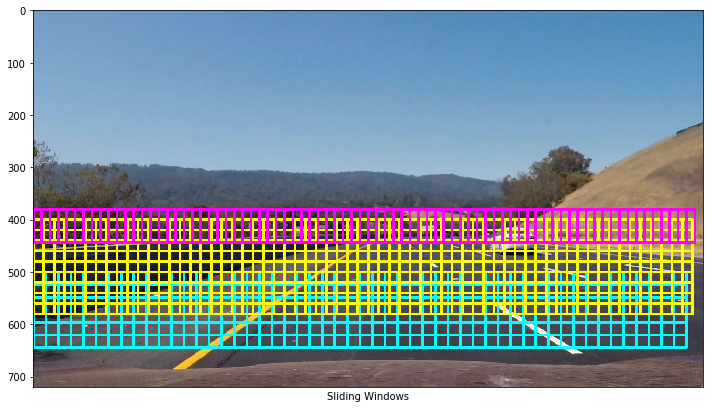

In [79]:
# For drawing boxes on images
def draw_windows(img, ystart, ystop, scale, pix_per_cell, cell_per_block, color):
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            startx = xbox_left
            starty = ytop_draw+ystart
            endx = xbox_left+win_draw
            endy = ytop_draw+win_draw+ystart
            window_list.append(((startx, starty), (endx, endy)))
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),color,3) 
                
    return draw_img

scales = [1.5, 1.25, 1.0]
y_start_stops = [(500,680),(400, 600),(380,460)]
colors = [(0,255,255),(255,255,0),(255,0,255)]

f, ax = plt.subplots(1, 1, figsize=(12,8))
img = mpimg.imread('test_images/test3.jpg')
draw_img = np.copy(img)

for i, scale in enumerate(scales):
    ystart, ystop = y_start_stops[i]
    draw_img = draw_windows(draw_img, ystart, ystop, scale, pix_per_cell, cell_per_block, colors[i])

ax.imshow(draw_img)
xlabel = "Sliding Windows"
ax.set_xlabel(xlabel)
ax.set_xticks([])
plt.savefig('output_images/sliding_window.png')
plt.show()

In [11]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_cars_boxes(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    box_list = []
    
    ystart = 500
    ystop = 700
    scale = 1.5
    box_list += (find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.25
    box_list += (find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 380
    ystop = 460
    scale = 1.0
    box_list += (find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    return box_list

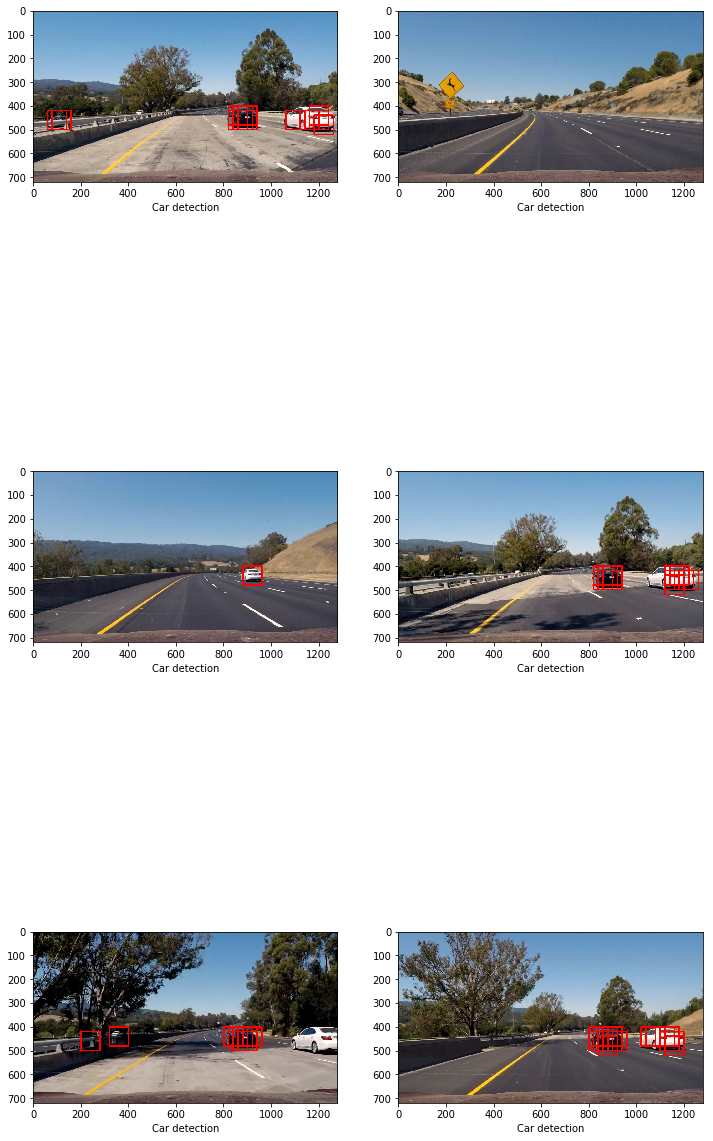

In [94]:
f, axes = plt.subplots(3, 2, figsize=(12,24))
axes = axes.flatten()

for i, image_p in enumerate(glob.glob('test_images/test*.jpg')):
    test_image = mpimg.imread(image_p)
    boxes = find_cars_boxes(test_image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    out_img = draw_boxes(test_image, boxes, color=(255, 0, 0), thick=5)
    axes[i].imshow(out_img)
    axes[i].set_xlabel('Car detection')
plt.savefig('output_images/car_detection.png')
plt.show()

In [87]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bbox

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

/Users/abhishekgurudurtt/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


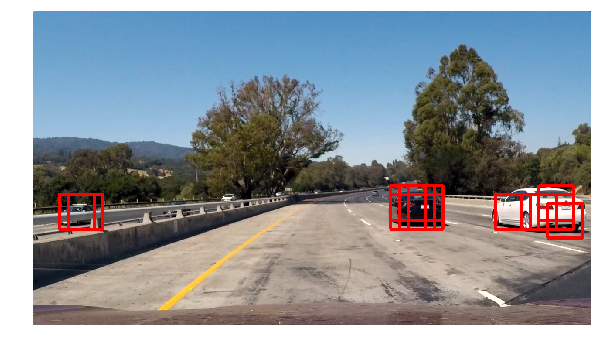

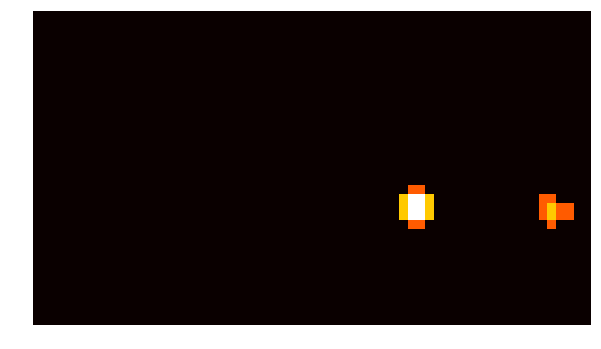

In [19]:
test_image = mpimg.imread('test_images/test1.jpg')
boxes = find_cars_boxes(test_image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img = draw_boxes(test_image, boxes, color=(255, 0, 0), thick=5)
plt.figure(figsize=(10,6))
plt.axis('off')
plt.imshow(out_img)

heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
heat = add_heat(heat,boxes)
heat = apply_threshold(heat,2)
plt.figure(figsize=(10,6))
plt.imshow(heat, cmap='hot')
plt.axis('off')
plt.show()

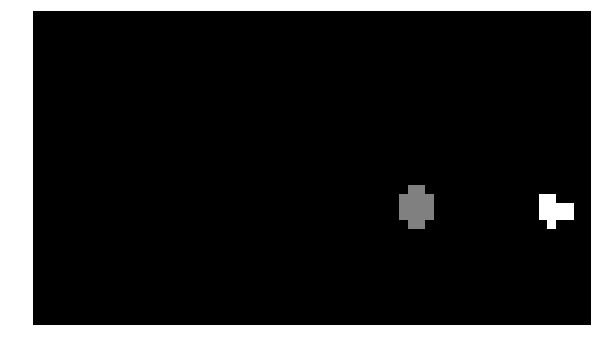

In [20]:
labels = label(heat)
plt.figure(figsize=(10,6))
plt.imshow(labels[0], cmap='gray')
plt.axis('off')
plt.show()

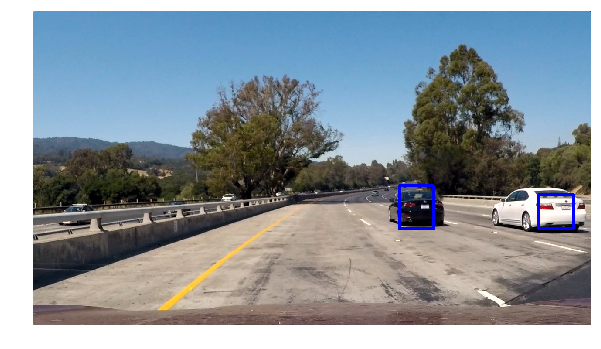

In [21]:
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
plt.figure(figsize=(10,6))
plt.imshow(draw_img)
plt.axis('off')
plt.show()

In [22]:
def detection_pipeline(img):
    boxes = find_cars_boxes(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,boxes)
    heat = apply_threshold(heat,3)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

/Users/abhishekgurudurtt/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


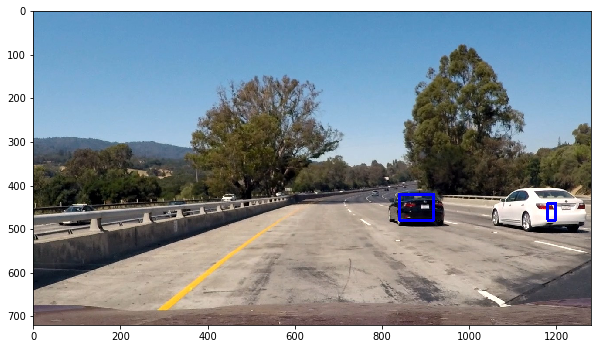

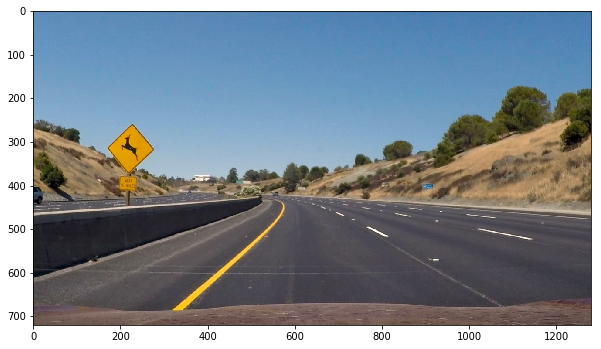

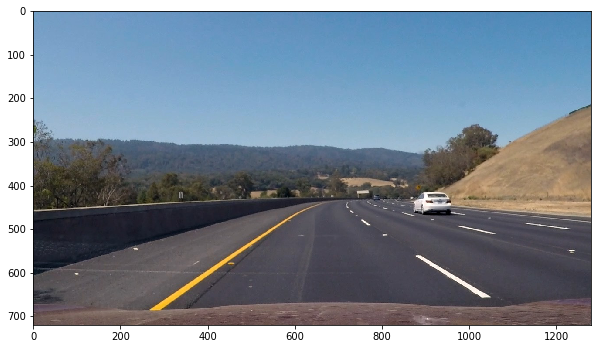

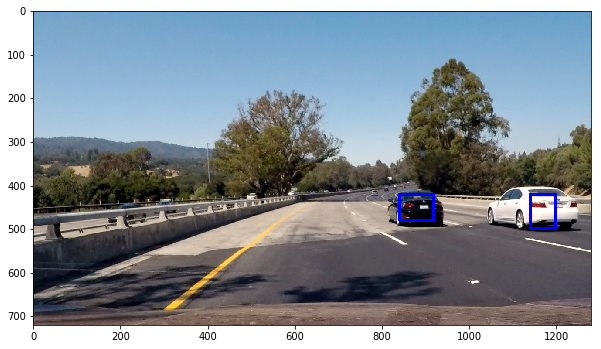

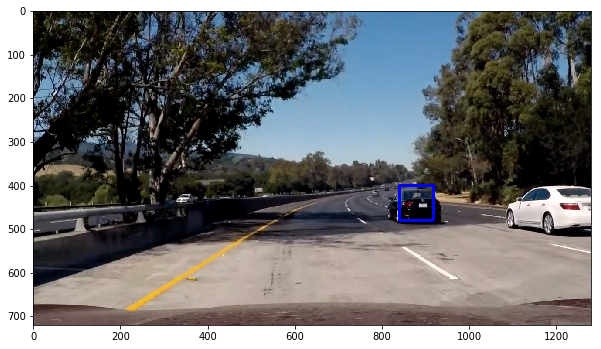

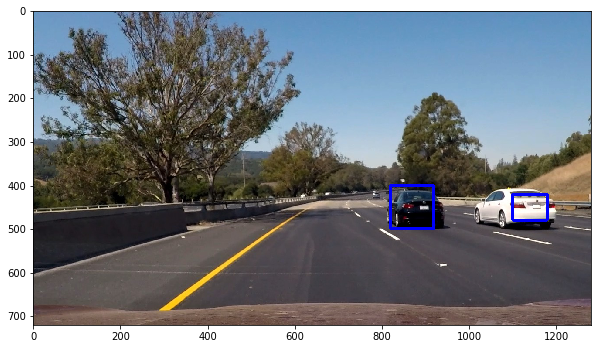

In [23]:
with open('parameter_value.p', mode='rb') as f:
    parameter_value = pickle.load(f)
    svc = parameter_value["svc"]
    X_scaler = parameter_value["X_scaler"]
    orient = parameter_value["orient"]
    pix_per_cell = parameter_value["pix_per_cell"]
    cell_per_block = parameter_value["cell_per_block"]
    spatial_size = parameter_value["spatial_size"]
    hist_bins = parameter_value["hist_bins"]

for image_p in glob.glob('test_images/test*.jpg'):
    test_image = mpimg.imread(image_p)
    out_img = detection_pipeline(test_image)
    plt.figure(figsize=(10,6))
    plt.imshow(out_img)
plt.show()

In [24]:
# Class to keep track of bounding boxes in successive frames of video
import collections

class CarBoxes(object):
    
    def __init__(self, num_frames=10):
        self.n = num_frames
        self.boxQ = collections.deque([], maxlen=num_frames)
        
    def add_boxes(self, boxes):
        self.boxQ.appendleft(boxes)
        
    def get_boxes(self):
        return list(self.boxQ)

In [51]:
carBoxes = CarBoxes(6)

def detection_pipeline_average(img):
    draw_image = np.copy(img)
    
    boxes = find_cars_boxes(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    carBoxes.add_boxes(boxes)
    boxes_list = carBoxes.get_boxes()
    
    for boxes in boxes_list:
        heat = add_heat(heat, boxes)
    heat  = apply_threshold(heat, 14)
    labels = label(heat)
    
    draw_img = draw_labeled_bboxes(draw_image, labels)
    return draw_img

In [52]:
from moviepy.editor import VideoFileClip
test_video = VideoFileClip('test_video.mp4')
processed_video = test_video.fl_image(detection_pipeline_average)

test_output_video = 'test_video_output.mp4'
%time processed_video.write_videofile(test_output_video, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4



 97%|█████████▋| 38/39 [00:26<00:00,  1.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 26.1 s, sys: 648 ms, total: 26.7 s
Wall time: 26.9 s


In [53]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output_video))

In [58]:
# get images from test video, to visualize heatmap and thresholding
test_clip = VideoFileClip("test_video.mp4")
test_imgs = test_clip.write_images_sequence('test_images/frame%04d.jpeg')

[MoviePy] Writing frames test_images/frame%04d.jpeg.


  0%|          | 0/1 [00:00<?, ?it/s]
2it [00:00, 15.34it/s]               
4it [00:00, 16.04it/s]
6it [00:00, 16.69it/s]
8it [00:00, 17.13it/s]
10it [00:00, 17.33it/s]
12it [00:00, 17.55it/s]
14it [00:00, 17.74it/s]
16it [00:00, 17.77it/s]
18it [00:01, 17.90it/s]
20it [00:01, 17.67it/s]
22it [00:01, 17.10it/s]
24it [00:01, 17.20it/s]
26it [00:01, 17.52it/s]
28it [00:01, 17.57it/s]
30it [00:01, 17.59it/s]
32it [00:01, 17.97it/s]
34it [00:01, 18.04it/s]
36it [00:02, 18.42it/s]
38it [00:02, 18.13it/s]

[MoviePy]: Done writing frames test_images/frame%04d.jpeg.



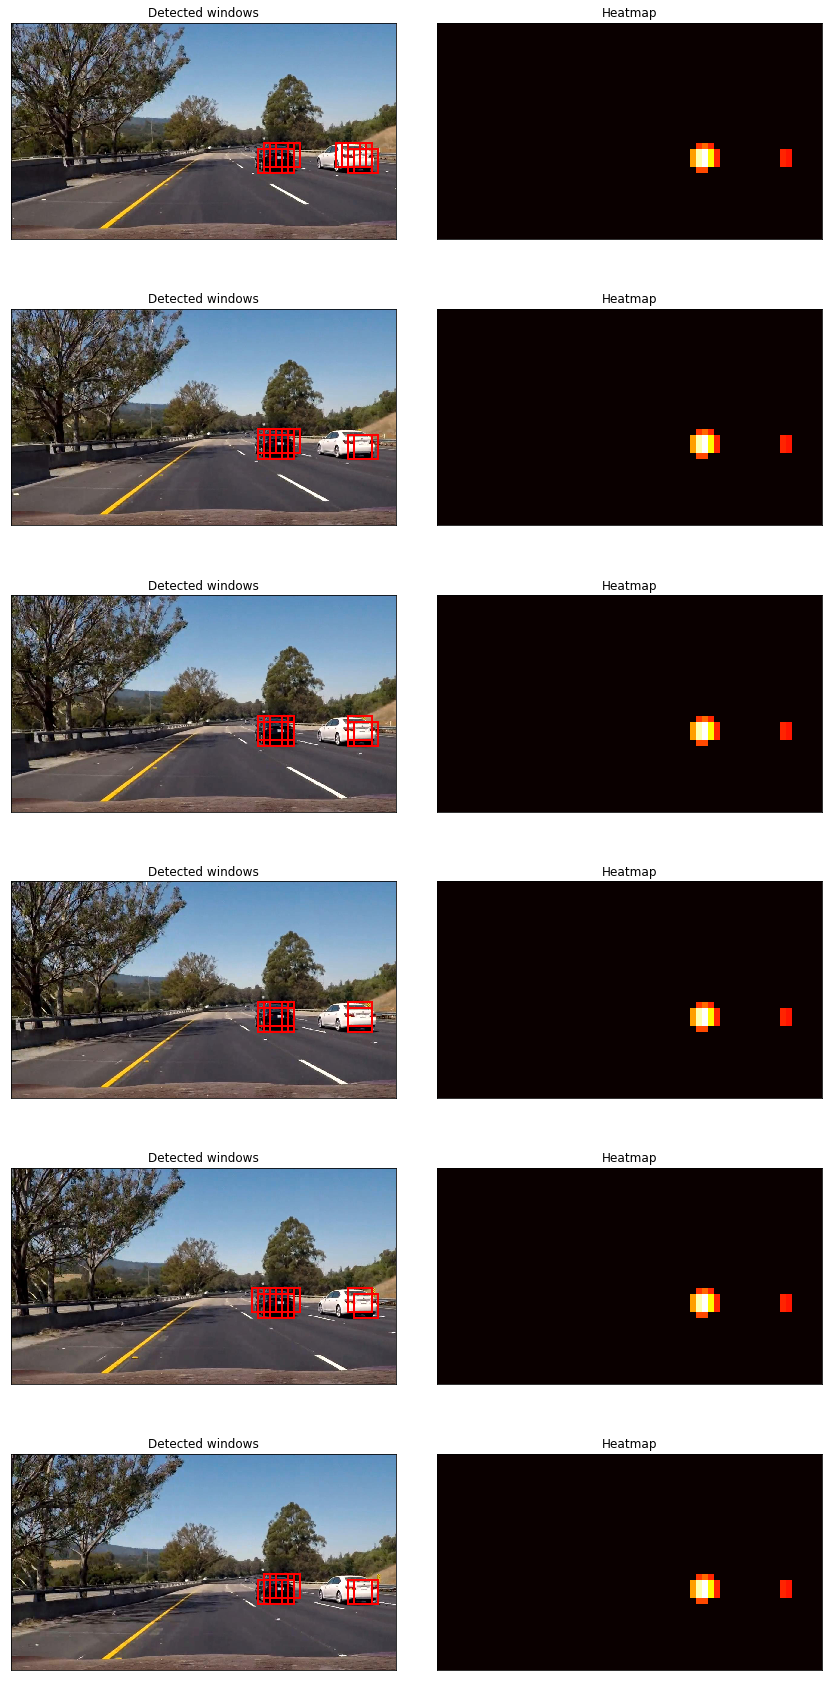

In [68]:
car_boxes = CarBoxes(6)
f, axes = plt.subplots(6, 2, figsize=(12,24))
axes = axes.flatten()
f.tight_layout()

for k, image_f in enumerate(test_imgs[10:16]):
    img = mpimg.imread(image_f)
    draw_image = np.copy(img)
    
    boxes = find_cars_boxes(draw_image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    carBoxes.add_boxes(boxes)
    boxes_list = carBoxes.get_boxes()
    
    for boxes in boxes_list:
        heat = add_heat(heat, boxes)
    heat  = apply_threshold(heat, 14)
    labels = label(heat)
    
    out_img = draw_boxes(img, boxes, color=(255, 0, 0), thick=5)
    
    i = 2*k
    axes[i].imshow(out_img)
    axes[i].set_title('Detected windows')
    axes[i].set_xticks([])
    axes[i].set_yticks([]) 
    
    axes[i+1].imshow(heat, cmap='hot')
    axes[i+1].set_title('Heatmap')
    axes[i+1].set_xticks([])
    axes[i+1].set_yticks([]) 
plt.savefig('output_images/video_pipeline.png')
plt.show()

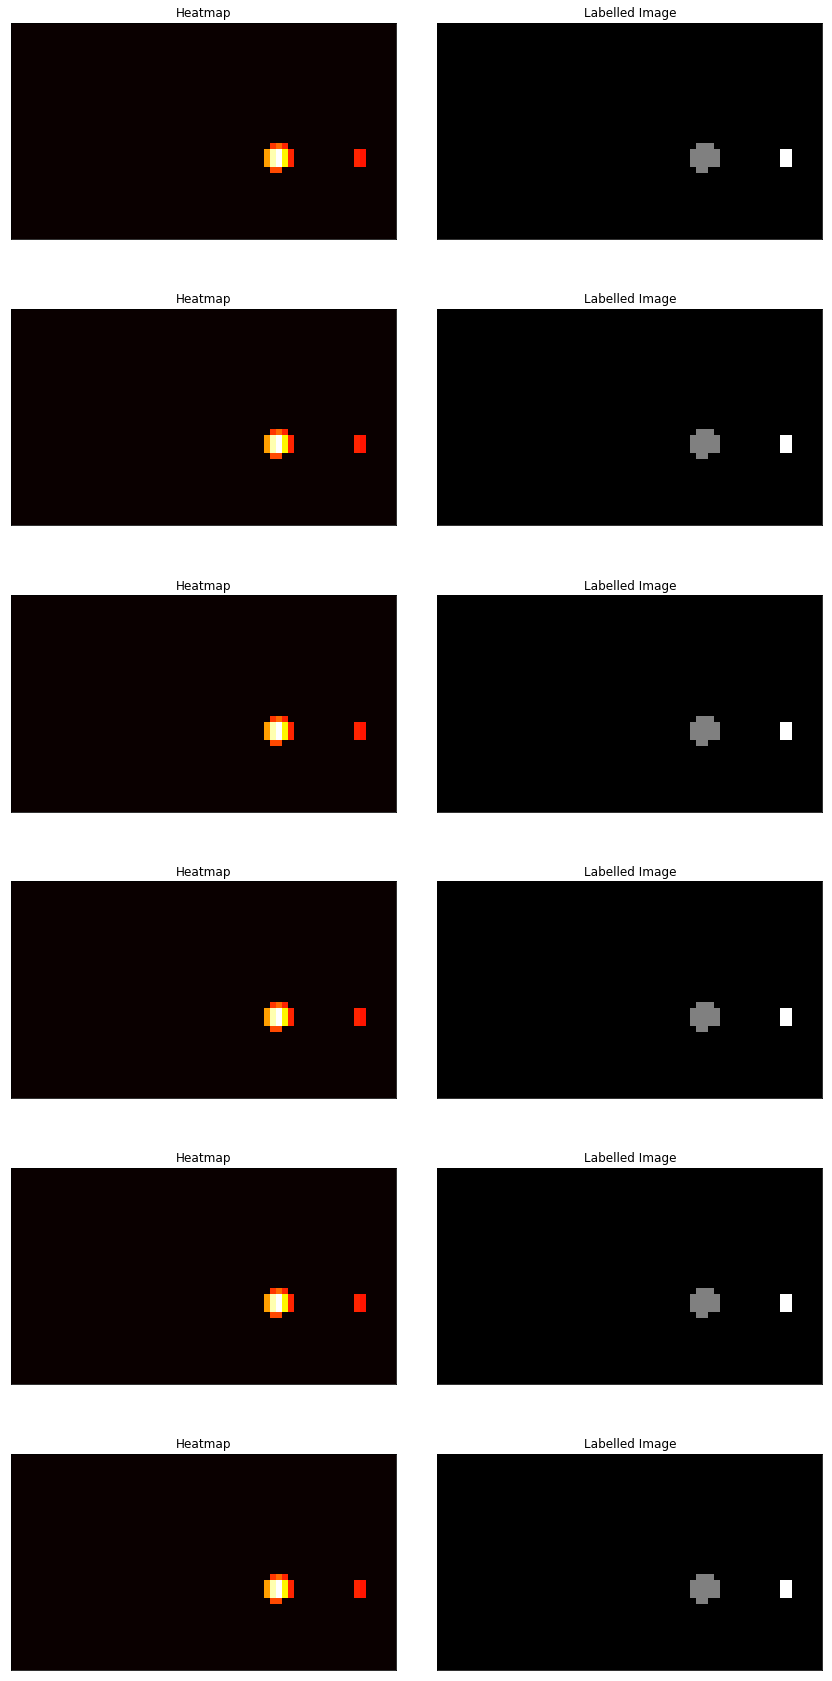

In [71]:
car_boxes = CarBoxes(6)
f, axes = plt.subplots(6, 2, figsize=(12,24))
axes = axes.flatten()
f.tight_layout()

for k, image_f in enumerate(test_imgs[10:16]):
    img = mpimg.imread(image_f)
    draw_image = np.copy(img)
    
    boxes = find_cars_boxes(draw_image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    carBoxes.add_boxes(boxes)
    boxes_list = carBoxes.get_boxes()
    
    for boxes in boxes_list:
        heat = add_heat(heat, boxes)
    heat  = apply_threshold(heat, 14)
    labels = label(heat)
     
    i = 2*k
    axes[i].imshow(heat, cmap='hot')
    axes[i].set_title('Heatmap')
    axes[i].set_xticks([])
    axes[i].set_yticks([]) 
    
    axes[i+1].imshow(labels[0], cmap='gray')
    axes[i+1].set_title('Labelled Image')
    axes[i+1].set_xticks([])
    axes[i+1].set_yticks([]) 
plt.savefig('output_images/labelled_pipeline.png')
plt.show()

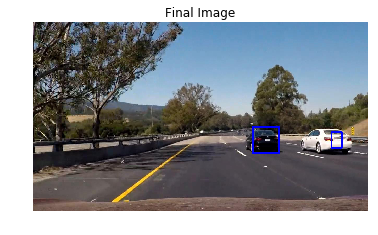

In [76]:
car_boxes = CarBoxes(6)
plt.figure()

for k, image_f in enumerate(test_imgs[10:16]):
    img = mpimg.imread(image_f)
    draw_image = np.copy(img)
    
    boxes = find_cars_boxes(draw_image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    carBoxes.add_boxes(boxes)
    boxes_list = carBoxes.get_boxes()
    
    for boxes in boxes_list:
        heat = add_heat(heat, boxes)
    heat  = apply_threshold(heat, 14)
    labels = label(heat)

    window_image = draw_labeled_bboxes(draw_image, labels)

    plt.imshow(window_image)
    plt.axis("off")
    plt.title('Final Image')

plt.savefig('output_images/final_image.png')
plt.show()

In [54]:
car_boxes = CarBoxes(6)

input_video = VideoFileClip('project_video.mp4')#.subclip(25,35)
processed_video = input_video.fl_image(detection_pipeline_average)

output_video = 'video_output.mp4'
%time processed_video.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video video_output.mp4
[MoviePy] Writing video video_output.mp4



 12%|█▏        | 152/1261 [01:40<11:53,  1.55it/s]


 24%|██▍       | 303/1261 [04:58<10:51,  1.47it/s]


 36%|███▌      | 454/1261 [06:40<09:02,  1.49it/s]


 48%|████▊     | 605/1261 [08:26<07:46,  1.41it/s]


 60%|█████▉    | 756/1261 [10:11<06:02,  1.39it/s]


 72%|███████▏  | 907/1261 [11:56<04:00,  1.47it/s]


 84%|████████▍ | 1057/1261 [13:37<02:16,  1.49it/s]


 96%|█████████▌| 1205/1261 [24:52<00:36,  1.53it/s]


100%|█████████▉| 1260/1261 [25:30<00:00,  1.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output.mp4 

CPU times: user 14min 22s, sys: 20.9 s, total: 14min 43s
Wall time: 25min 30s


In [56]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))